## Try different algorithms for base and meta estimators

### Background
Experiments and testing for the initial model demonstrated best performance with a model based on an `xgboost` regressor. With the change from `XGBRegressor` with bagging to a stacking model, I broke out the Elo model that was embedded in the `xgboost` model, and added another `XGBRegressor` as the meta estimator. As one of the base models, `XGBRegressor` is still likely one of the better options, but I've recently heard of `CatBoost` and `LightGBM` (I'll be using Scikit-learns' `HistGradientBoostingRegressor` instead to avoid adding an extra dependency), and they might perform better. Also, I haven't tested any other algorithms for the meta estimator, so I should try a wide variety for thoroughness.

### Hypothesis
* An alternative flavour of gradient boosting might outperform `XGBRegressor`.
* `XGBRegressor` might not be the best algorithm for the meta estimator.

## Code Setup

In [1]:
%load_ext autoreload

In [65]:
%autoreload 2
# %reload_kedro

from functools import partial
from itertools import product

import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge, OrthogonalMatchingPursuit, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor
import seaborn as sns

from augury import model_tracking
from augury.ml_data import MLData
from augury.ml_estimators import StackingEstimator
from augury.settings import CV_YEAR_RANGE, SEED

from src.model.charts import graph_cv_model_performance

In [3]:
np.random.seed(SEED)

In [15]:
data = MLData(train_year_range=(CV_YEAR_RANGE[1],))
data.data

2019-12-29 08:35:35,912 - kedro.io.data_catalog - INFO - Loading data from `model_data` (JSONLocalDataSet)...


team   oppo_team round_type  \
Adelaide         1991 1           Adelaide    Hawthorn    Regular   
                      2           Adelaide     Carlton    Regular   
                      3           Adelaide      Sydney    Regular   
                      4           Adelaide    Essendon    Regular   
                      5           Adelaide  West Coast    Regular   
...                                    ...         ...        ...   
Western Bulldogs 2019 20  Western Bulldogs    Brisbane    Regular   
                      21  Western Bulldogs    Essendon    Regular   
                      22  Western Bulldogs         GWS    Regular   
                      23  Western Bulldogs    Adelaide    Regular   
                      24  Western Bulldogs         GWS     Finals   

                                      venue prev_match_oppo_team  \
Adelaide         1991 1       Football Park                    0   
                      2       Football Park             Hawthorn   
                      3              S.C.G.              Carlton   
                      4          Windy Hill               Sydney   
                      5             Subiaco             Essendon   
...                                     ...                  ...   
Western Bulldogs 2019 20              Gabba            Fremantle   
                      21          Docklands             Brisbane   
                      22  Sydney Showground             Essendon   
                      23     Eureka Stadium                  GWS   
                      24  Sydney Showground             Adelaide   

                         oppo_prev_match_oppo_team                      date  \
Adelaide         1991 1                  Melbourne 1991-03-22 03:56:00+00:00   
                      2                    Fitzroy 1991-03-31 03:56:00+00:00   
                      3                   Hawthorn 1991-04-07 03:05:00+00:00   
                      4            North Melbourne 1991-04-13 03:30:00+00:00   
                      5            North Melbourne 1991-04-21 05:27:00+00:00   
...                                            ...                       ...   
Western Bulldogs 2019 20                  Hawthorn 2019-08-04 02:58:00+00:00   
                      21             Port Adelaide 2019-08-10 03:30:00+00:00   
                      22                  Hawthorn 2019-08-18 03:05:00+00:00   
                      23               Collingwood 2019-08-25 03:30:00+00:00   
                      24                Gold Coast 2019-09-07 03:05:00+00:00   

                          team_goals  team_behinds  score  ...  \
Adelaide         1991 1           24            11    155  ...   
                      2           12             9     81  ...   
                      3           19            18    132  ...   
                      4            6            11     47  ...   
                      5            9            11     65  ...   
...                              ...           ...    ...  ...   
Western Bulldogs 2019 20          11            14     80  ...   
                      21          21            11    137  ...   
                      22          19            12    126  ...   
                      23          18            13    121  ...   
                      24           8             7     55  ...   

                          oppo_rolling_prev_match_goals_divided_by_rolling_prev_match_goals_plus_rolling_prev_match_behinds  \
Adelaide         1991 1                                                 0.0                                                   
                      2                                                 0.0                                                   
                      3                                                 0.0                                                   
                      4                                                 0.0                                                   
   

## Run experiment

### Test different algorithms, one level at a time

For the list of algorithms to try, I'm selecting ones that have performed well while building earlier versions of the model and a few that I haven't tried before. It's not very scientific, but I want to limit how long it takes to run through them all. Also, instead of testing all possible permutations of base and meta estimators, I'll test one level at a time. This allows for testing more algorithms, but risks missing the best overall permutation, which is a tradeoff I'm willing to make to keep from having to run cross-validation for days.

In [33]:
label = 'algorithm_selection'
default_estimator = StackingEstimator()

estimators = [
    # XGBRegressor is currently the default for both the base & meta estimators,
    # so we don't need to include it in the list of test models.
    # The current default is defined below.
    # XGBRegressor(objective="reg:squarederror", random_state=SEED),
    CatBoostRegressor(random_seed=SEED),
    GradientBoostingRegressor(random_state=SEED),
    HistGradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED),
    LinearSVR(),
    Ridge(),
    Lasso(),
    OrthogonalMatchingPursuit(),
    KNeighborsRegressor(),
]

models = []

for level in ['pipeline-1', 'meta_regressor']:
    pipeline_steps = 'pipeline__' + level + '__steps'

    for estimator in estimators:
        estimator_name = estimator.__class__.__name__.lower()
        this_estimator = clone(default_estimator)
        this_estimator.get_params().get(pipeline_steps)[-1] = (estimator_name, estimator)
        
        base_estimator_name = estimator_name if level == 'pipeline-1' else 'xgbregressor'
        meta_estimator_name = estimator_name if level == 'meta_regressor' else 'xgbregressor'
        experiment_value = 'base_' + base_estimator_name + '_meta_' + meta_estimator_name
        
        run_info = {'run_tags': {'experiment': label}, 'run_params': {'experiment_value': experiment_value}}

        models.append((this_estimator, data, run_info))

In [34]:
cv_scores = model_tracking.start_run(models, n_jobs=-1)
cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
2019/12/29 09:05:54 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

[Parallel(n_jobs=-1)]: Using backend LokyBa

[{'model': 'stacking_estimator',
  'fit_time': array([115.69948673, 115.3591485 , 116.81113315, 116.9778564 ,
          33.1164968 ]),
  'score_time': array([0.3833766 , 0.39018917, 0.31655788, 0.36965132, 0.28214622]),
  'test_match_accuracy': array([0.69565217, 0.69902913, 0.73429952, 0.70048309, 0.72463768]),
  'test_neg_mean_absolute_error': array([-31.98970896, -32.47165244, -29.8878428 , -29.1322752 ,
         -28.63339738])},
 {'model': 'stacking_estimator',
  'fit_time': array([107.04028988, 110.28162122, 114.82164288, 117.43089986,
          98.09651709]),
  'score_time': array([0.32277918, 0.31786799, 0.36879516, 0.32326531, 0.26139474]),
  'test_match_accuracy': array([0.71497585, 0.69902913, 0.71497585, 0.69082126, 0.7294686 ]),
  'test_neg_mean_absolute_error': array([-29.78818357, -30.91043476, -28.73628801, -28.50370121,
         -26.65053695])},
 {'model': 'stacking_estimator',
  'fit_time': array([32.31195521, 27.79759002, 29.77389884, 28.2174716 , 19.71376228]),
  'sc

In [60]:
mean_scores = []

for idx, results in enumerate(cv_scores):
    est_idx = idx % len(estimators)
    est_label = f"{'base' if idx < len(estimators) else 'meta'}_{estimators[est_idx].__class__.__name__}"
    
    mean_scores.append(
        {
            'model': est_label,
            'fit_time': results['fit_time'].mean(),
            'match_accuracy': results['test_match_accuracy'].mean(),
            'mae': abs(results['test_neg_mean_absolute_error'].mean()),
        }
    )

    print('estimator:', est_label)
    print('mean fit time:', results['fit_time'].mean())
    print('mean match accuracy:', results['test_match_accuracy'].mean())
    print('mean MAE:', abs(results['test_neg_mean_absolute_error'].mean()))
    print('')
    
mean_scores_df = pd.DataFrame(mean_scores)

estimator: base_CatBoostRegressor
mean fit time: 99.59282431602477
mean match accuracy: 0.7108203179963417
mean MAE: 30.422975356346114

estimator: base_GradientBoostingRegressor
mean fit time: 109.53419418334961
mean match accuracy: 0.7098541344214624
mean MAE: 28.91782889900791

estimator: base_HistGradientBoostingRegressor
mean fit time: 27.56293559074402
mean match accuracy: 0.7137329393555649
mean MAE: 31.459515851089588

estimator: base_ExtraTreesRegressor
mean fit time: 139.12277493476867
mean match accuracy: 0.7263167768866376
mean MAE: 28.083603396035677

estimator: base_LinearSVR
mean fit time: 6.439385223388672
mean match accuracy: 0.6924534496505793
mean MAE: 29.091056170217303

estimator: base_Ridge
mean fit time: 4.245114517211914
mean match accuracy: 0.6924581398621078
mean MAE: 29.013066703279897

estimator: base_Lasso
mean fit time: 5.012112760543824
mean match accuracy: 0.7031002298203649
mean MAE: 28.779839169714847

estimator: base_OrthogonalMatchingPursuit
mean fit

2019-12-29 10:07:50,191 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


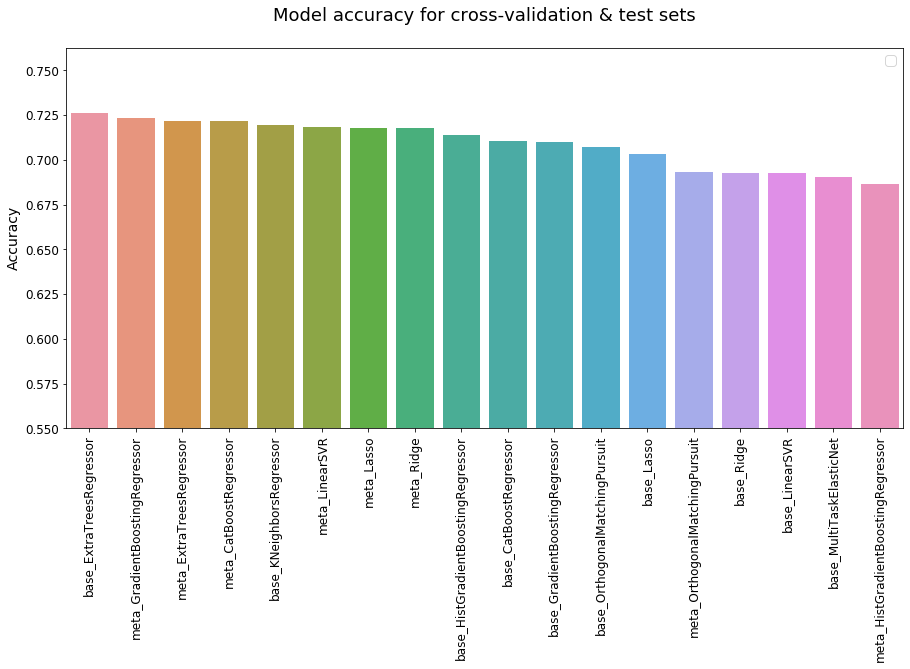

2019-12-29 10:07:50,669 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


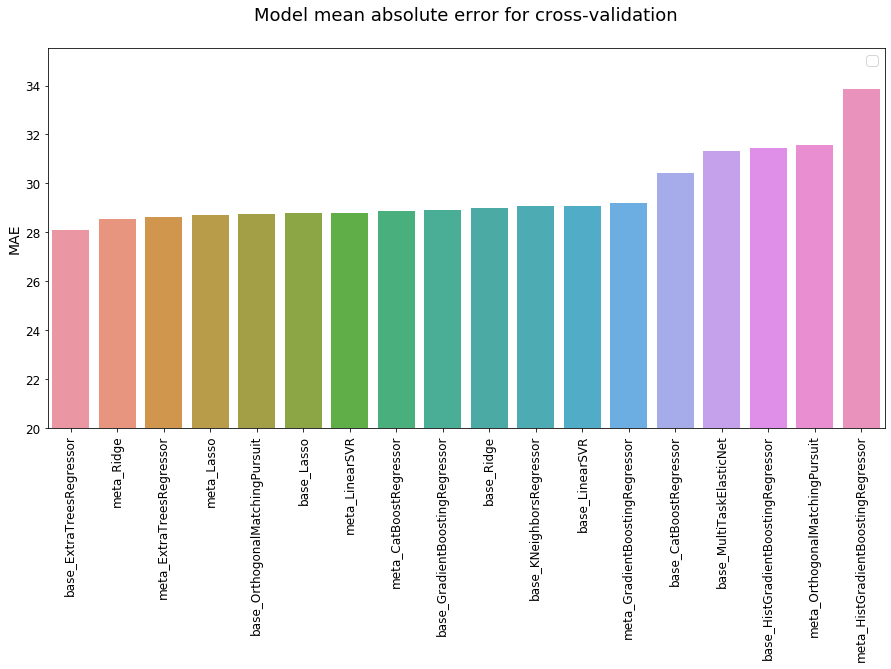

In [64]:
graph_cv_model_performance(mean_scores_df)

### Try full permutations of top models

`ExtraTreesRegressor` performed significantly better than other models across both accuracy and MAE, but I want to try a few of the top models in all possible permutations, with a focus on high-accuracy models. This is a change from last season, where I focused more on MAE due to a mis-interpretation of a mathy blog post. Accuracy is where the money is, so I will optimise for that, using MAE is a secondary metric and/or tie-breaker.

In [75]:
label = 'algorithm_selection'
default_estimator = StackingEstimator()

estimators = [
    XGBRegressor(objective="reg:squarederror", random_state=SEED),
    CatBoostRegressor(random_seed=SEED),
    GradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED),
]

est_product = list(product(estimators, repeat=2))

models = []

for base_estimator, meta_estimator in est_product:
    this_estimator = clone(default_estimator)

    base_name = base_estimator.__class__.__name__.lower()
    this_estimator.get_params().get('pipeline__pipeline-1__steps')[-1] = (base_name, base_estimator)
    
    meta_name = meta_estimator.__class__.__name__.lower()
    this_estimator.get_params().get('pipeline__meta_regressor__steps')[-1] = (meta_name, meta_estimator)
    
    experiment_value = 'base_' + base_name + '_meta_' + meta_name

    run_info = {'run_tags': {'experiment': label}, 'run_params': {'experiment_value': experiment_value}}

    models.append((this_estimator, data, run_info))

In [79]:
cv_scores = model_tracking.start_run(models, n_jobs=-1)
cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3mi

[{'model': 'stacking_estimator',
  'fit_time': array([19.85772538, 20.49239182, 20.91760278, 21.51458931, 19.86533999]),
  'score_time': array([0.26857781, 0.27498341, 0.25891256, 0.25910354, 0.23168182]),
  'test_match_accuracy': array([0.7294686 , 0.72815534, 0.73429952, 0.66666667, 0.73429952]),
  'test_neg_mean_absolute_error': array([-29.61610675, -31.0290287 , -28.5355068 , -28.91593467,
         -26.52216876])},
 {'model': 'stacking_estimator',
  'fit_time': array([31.88839221, 32.39447546, 34.75808716, 34.81717849, 24.89729571]),
  'score_time': array([1.07145929, 0.45608211, 0.30284667, 0.2799685 , 0.26509762]),
  'test_match_accuracy': array([0.71980676, 0.72815534, 0.73429952, 0.66666667, 0.74879227]),
  'test_neg_mean_absolute_error': array([-29.97516864, -31.2640012 , -28.93832388, -28.8553127 ,
         -26.33904518])},
 {'model': 'stacking_estimator',
  'fit_time': array([19.85238361, 20.65734529, 21.23564219, 21.70881867, 20.4823637 ]),
  'score_time': array([0.29519343

In [84]:
est_product = list(product(estimators, repeat=2))
mean_scores = []

for idx, results in enumerate(cv_scores):
    est_idx = idx % len(est_product)
    est_label = 'base_' + est_product[est_idx][0].__class__.__name__ + '_meta_' + est_product[est_idx][1].__class__.__name__
    
    mean_scores.append(
        {
            'model': est_label,
            'fit_time': results['fit_time'].mean(),
            'match_accuracy': results['test_match_accuracy'].mean(),
            'mae': abs(results['test_neg_mean_absolute_error'].mean()),
        }
    )

    print('estimator:', est_label)
    print('mean fit time:', results['fit_time'].mean())
    print('mean match accuracy:', results['test_match_accuracy'].mean())
    print('mean MAE:', abs(results['test_neg_mean_absolute_error'].mean()))
    print('')
    
mean_scores_df = pd.DataFrame(mean_scores)

estimator: base_XGBRegressor_meta_XGBRegressor
mean fit time: 20.5295298576355
mean match accuracy: 0.7185779278645467
mean MAE: 28.923749136958428

estimator: base_XGBRegressor_meta_CatBoostRegressor
mean fit time: 31.751085805892945
mean match accuracy: 0.7195441114394259
mean MAE: 29.07437032120355

estimator: base_XGBRegressor_meta_GradientBoostingRegressor
mean fit time: 20.787310695648195
mean match accuracy: 0.7214764785891844
mean MAE: 28.881829378999033

estimator: base_XGBRegressor_meta_ExtraTreesRegressor
mean fit time: 21.791886377334595
mean match accuracy: 0.6866797992589466
mean MAE: 33.848732540687585

estimator: base_CatBoostRegressor_meta_XGBRegressor
mean fit time: 92.07296514511108
mean match accuracy: 0.7108203179963417
mean MAE: 30.422975356346114

estimator: base_CatBoostRegressor_meta_CatBoostRegressor
mean fit time: 104.12180542945862
mean match accuracy: 0.7137188687209794
mean MAE: 30.854879130439407

estimator: base_CatBoostRegressor_meta_GradientBoostingReg

2019-12-29 19:29:07,105 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


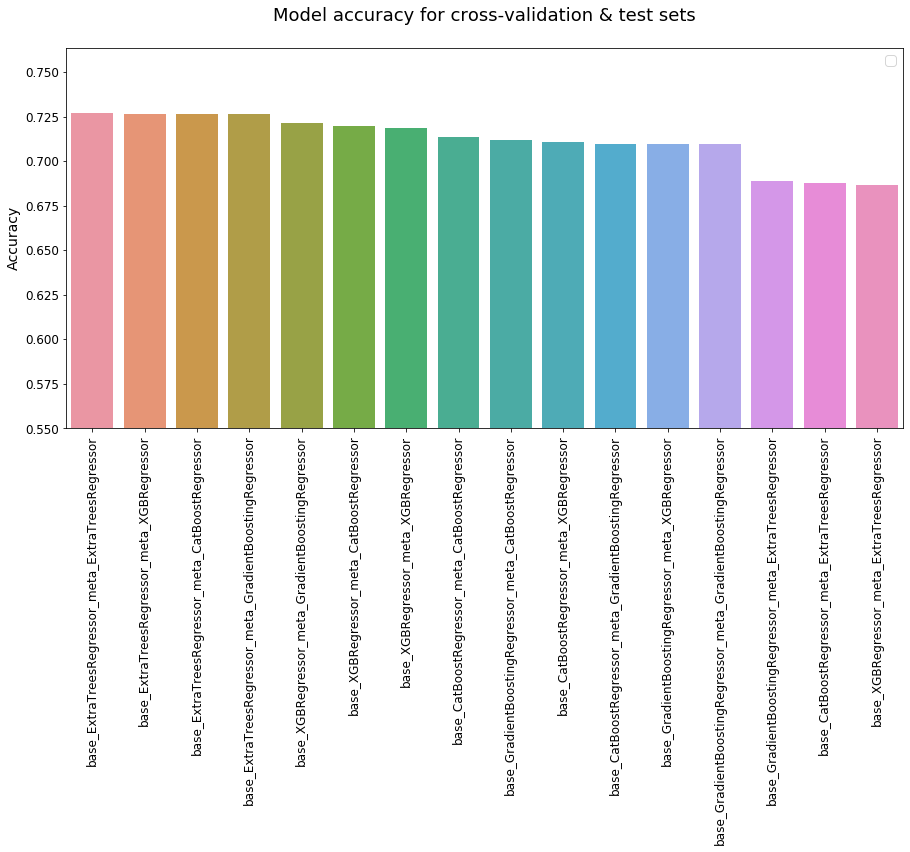

2019-12-29 19:29:07,641 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


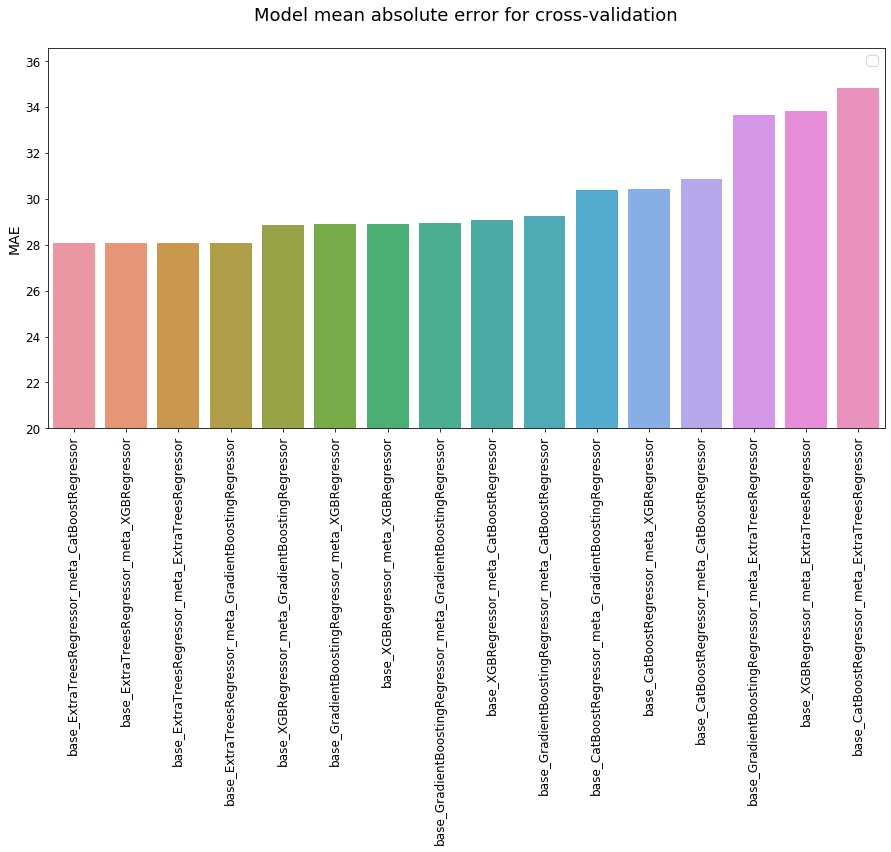

In [85]:
graph_cv_model_performance(mean_scores_df)

## Conclusion

### ExtraTrees is the best sub-model for now
Four combinations perform noticeably better than the rest:
* ExtraTrees base + ExtraTrees meta
* ExtraTrees base + XGB meta
* ExtraTrees base + CatBoost meta
* ExtraTrees base + GradientBoosting meta

ExtraTrees for both sub-models has the highest accuracy, so I will use that combination for now, but it will be worth revisiting when it's time to tune params. Also, it might be worthwhile adding the above models as base models in the `StackingEstimator`, but the added training time might not be worth it depending on how large the improvement is.